In [284]:
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad as integral
from collections import OrderedDict
%matplotlib nbagg

http://www.qfa.uam.es/qcomp/presentaciones/Tema3.pdf 

In [13]:
BDIR=f"./"

In [14]:
FIGDIR=f"{BDIR}/figures/"

In [3]:
def MLestimator(params,data,pdf,pdfparams):
    pass

### Generating numbers

In [20]:
np.random.uniform?

In [55]:
#Distributed normally
NPOINTS=1000
POP_MEAN=0.0
POP_STD=0.5
x=np.random.normal(POP_MEAN,POP_STD,NPOINTS)
y=np.random.uniform(0,1,NPOINTS)
xt=np.linspace(x.min(),x.max(),100)

In [52]:
def myNorm(x,mean,sigma):
    N=1/np.sqrt(2*np.pi*sigma)
    y=np.exp(-(x-mean)**2/(2*sigma**2))
    return N*y

In [53]:
norm.pdf(0,0,1)

0.3989422804014327

<IPython.core.display.Javascript object>


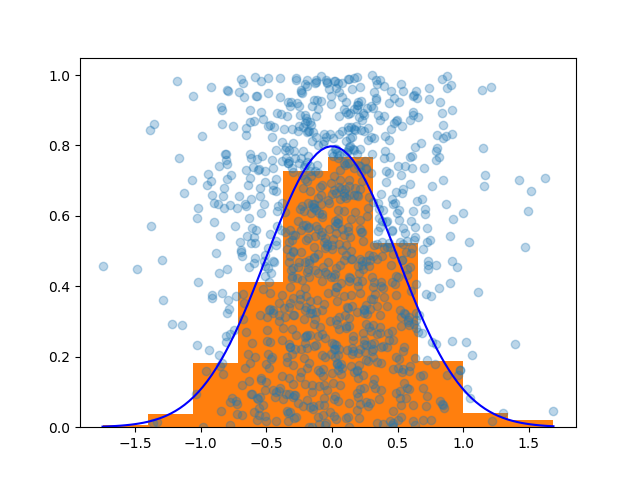

In [56]:
fig=plt.figure()
ax=fig.gca()

ax.plot(x,y,'o',alpha=0.3)
ax.hist(x,10,normed=True)
ax.plot(xt,norm.pdf(xt,POP_MEAN,POP_STD),'b-')

fig.savefig(f"{FIGDIR}/test.png")

In [35]:
def gaussianSeries(params,ngaussians):
    centers=params[:ngaussians]
    sigmas=params[ngaussians:]
    print(centers,sigmas)

In [36]:
gparams=[1.0,0.5]

In [37]:
gaussianSeries(gparams,1)

[1.0] [0.5]


In [139]:
def rejectionGenerate(pdf,N,xmin,xmax,**args):
    xmed=(xmin+xmax)/2
    ipdf=lambda x:-pdf(x,**args)
    solution=minimize(ipdf,xmed)
    maxval=-solution.fun[0]
    xs=np.zeros(N)
    for n in range(N):
        p=0;u=1
        while u>p:
            x=np.random.uniform(xmin,xmax)
            p=-ipdf(x)
            u=np.random.uniform(0,maxval)
        xs[n]=x
    return xs

In [140]:
pdfparams=dict(loc=0.0,scale=1.0)
%timeit -n 10 rejectionGenerate(norm.pdf,1,-10,10,**pdfparams)

10 loops, best of 3: 1.94 ms per loop


In [151]:
TEST_MEAN=2.0
TEST_STD=0.5

pdfparams=dict(loc=TEST_MEAN,scale=TEST_STD)
x=rejectionGenerate(norm.pdf,NPOINTS,TEST_MEAN-5*TEST_STD,TEST_MEAN+5*TEST_STD,**pdfparams)
y=np.random.uniform(0,1,NPOINTS)
xt=np.linspace(x.min(),x.max(),100)

<IPython.core.display.Javascript object>


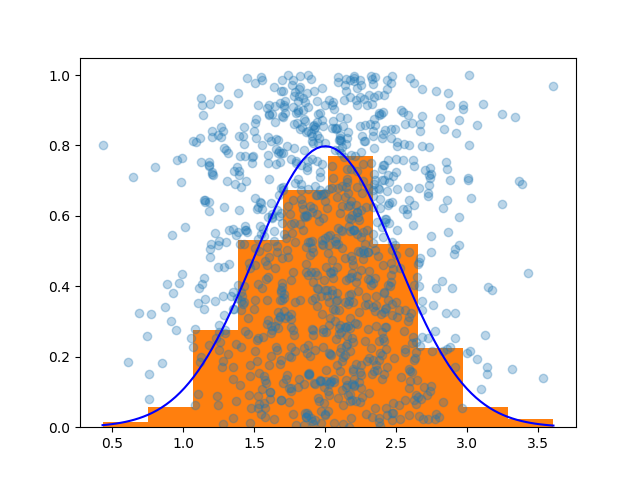

In [152]:
fig=plt.figure()
ax=fig.gca()

ax.plot(x,y,'o',alpha=0.3)
ax.hist(x,10,normed=True)
ax.plot(xt,norm.pdf(xt,TEST_MEAN,TEST_STD),'b-')

fig.savefig(f"{FIGDIR}/test.png")

In [178]:
def multiNorm(x,ngaussians=None,params=None):
    locs=params[:ngaussians]
    scales=params[ngaussians:]
    y=0
    for n in range(ngaussians):
        y+=norm.pdf(x,loc=locs[n],scale=scales[n])
    return y

def minmaxMultiNorm(ngaussians,params=None,nsigma=5.0):
    locs=np.array(params[:ngaussians])
    scales=np.array(params[ngaussians:])
    xmins=locs-nsigma*scales
    xmaxs=locs+nsigma*scales
    return xmins.min(),xmaxs.max()

In [179]:
locs=[-2,2]
scales=[1.0,1.0]
x=0
ngaussians=2
y=multiNorm(x,ngaussians,locs[:ngaussians]+scales[:ngaussians])
print(y)
xmin,xmax=minmaxMultiNorm(ngaussians,locs[:ngaussians]+scales[:ngaussians],nsigma=2)
print(xmin,xmax)

0.10798193302637613
-4.0 4.0


<IPython.core.display.Javascript object>


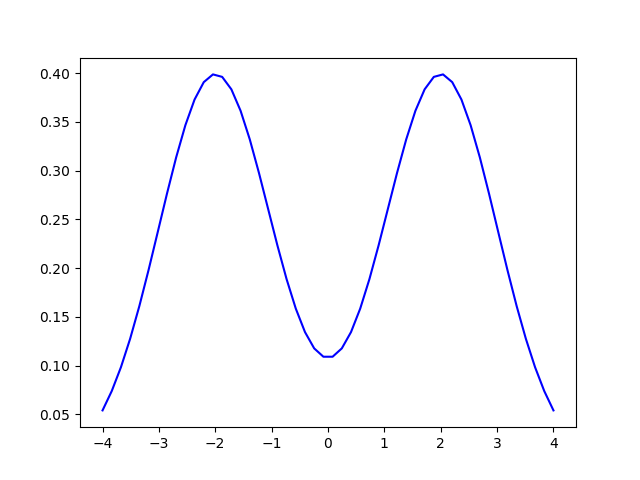

In [180]:
fig=plt.figure()
ax=fig.gca()

xt=np.linspace(xmin,xmax)
ax.plot(xt,multiNorm(xt,ngaussians,locs[:ngaussians]+scales[:ngaussians]),'b-')

fig.savefig(f"{FIGDIR}/test_multinorm.png")

In [188]:
ngaussians

2

In [330]:
def multiNorm(x,ngaussians=None,params=None):
    weights=params[:ngaussians]
    locs=params[ngaussians:2*ngaussians]
    scales=params[2*ngaussians:]
    y=0
    for n in range(ngaussians):
        y+=weights[n]*norm.pdf(x,loc=locs[n],scale=scales[n])
    return y

def minmaxMultiNorm(ngaussians,params=None,nsigma=5.0):
    weights=np.array(params[:ngaussians])
    locs=np.array(params[ngaussians:2*ngaussians])
    scales=np.array(params[2*ngaussians:])
    xmins=locs-nsigma*scales
    xmaxs=locs+nsigma*scales
    return xmins.min(),xmaxs.max()

def pdfMax(pdf,xmin,xmax,**args):
    ipdf=lambda x:-pdf(x,**args)

    globalmaxval=-1e100
    for xtest in np.linspace(xmin,xmax,10):
        solution=minimize(ipdf,xtest)
        #print(f"Solution using {xtest}:")
        #print(solution)
        try:
            maxval=-solution.fun[0]
        except:
            maxval=-solution.fun
        if maxval>globalmaxval:
            globalmaxval=maxval
    globalmaxval*=1.01
    return globalmaxval

def pdfNorm(pdf,xmin,xmax,**args):
    N,dN=integral(pdf,xmin,xmax,args=tuple(args.values()))
    return N

def rejectionGenerate(pdf,N,xmin,xmax,maxval,**args):
    #Factor 1.01 is to avoid symmetrical functions
    xs=np.zeros(N)
    for n in range(N):
        p=0;u=1
        while u>p:
            x=np.random.uniform(xmin,xmax)
            p=pdf(x,**args)
            u=np.random.uniform(0,maxval)
        xs[n]=x
    return xs

In [338]:
weights=[1.0,2.0]
locs=[-2.0,2.0]
scales=[1,1]
ngaussians=2

pdfparams=OrderedDict(ngaussians=ngaussians,params=weights[:ngaussians]+locs[:ngaussians]+scales[:ngaussians])
xmin,xmax=minmaxMultiNorm(nsigma=5,**pdfparams)
pdfmax=pdfMax(multiNorm,xmin,xmax,**pdfparams)
N=pdfNorm(multiNorm,xmin,xmax,**pdfparams)
print(f"xmin = {xmin}, xmax = {xmax}, pdfmax = {pdfmax/N}, Normalization = {N}")

xmin = -7.0, xmax = 7.0, pdfmax = 0.26866632927120554, Normalization = 2.9999991400452846


<IPython.core.display.Javascript object>


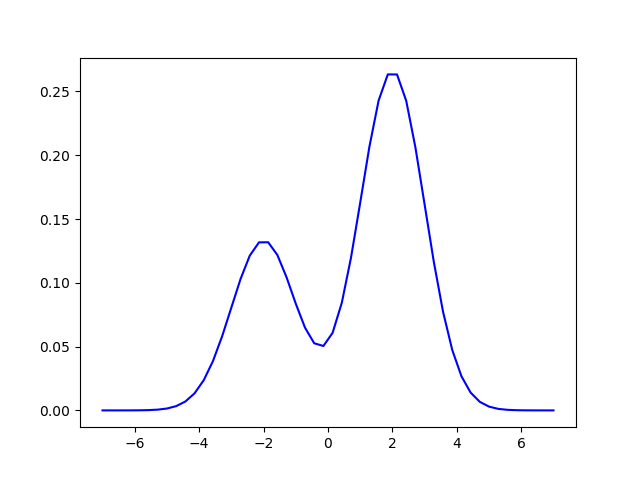

In [337]:
fig=plt.figure()
ax=fig.gca()

xt=np.linspace(xmin,xmax)
ax.plot(xt,multiNorm(xt,**pdfparams)/N,'b-')

fig.savefig(f"{FIGDIR}/test_multinorm.png")

In [339]:
x=rejectionGenerate(multiNorm,NPOINTS,xmin,xmax,pdfmax,**pdfparams)
xt=np.linspace(xmin,xmax,100)
yt=multiNorm(xt,**pdfparams)/N
ymax=yt.max()
y=np.random.uniform(0,ymax,NPOINTS)

<IPython.core.display.Javascript object>


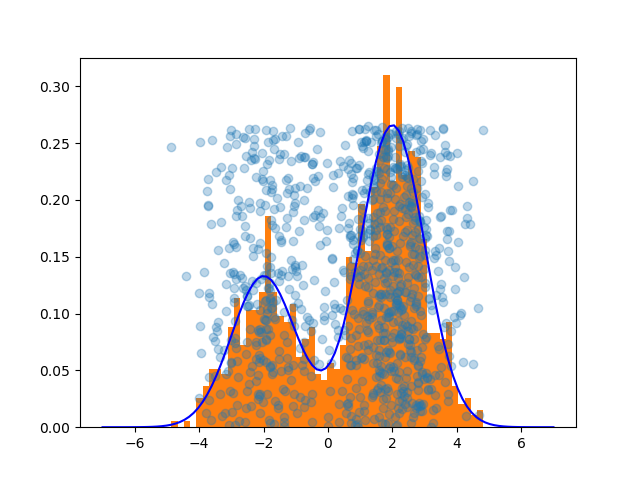

In [340]:
fig=plt.figure()
ax=fig.gca()

ax.plot(x,y,'o',alpha=0.3)
ax.hist(x,50,normed=True)
ax.plot(xt,yt,'b-')

fig.savefig(f"{FIGDIR}/test.png")

### Kolmogorov-Smirnov tests

In [343]:
weights=[1.0,2.0]
locs=[-2.0,2.0]
scales=[1,1]
ngaussians=2
pdfparams=OrderedDict(ngaussians=ngaussians,params=weights[:ngaussians]+locs[:ngaussians]+scales[:ngaussians])
npoints=100

x=rejectionGenerate(multiNorm,npoints,xmin,xmax,pdfmax,**pdfparams)

In [349]:
from scipy.stats import kstest
from scipy import stats

In [413]:
xg=np.random.normal(locs[0],scales[0],npoints)

In [414]:
kstest(xg,"norm",args=(locs[0],scales[0]))

KstestResult(statistic=0.1066322151090886, pvalue=0.1914951088080843)

In [359]:
stats.kstest(stats.norm.rvs(size=100,loc=1,scale=1), 'norm',args=(1,1))

KstestResult(statistic=0.07707679169654147, pvalue=0.5796319363738138)

In [435]:
x=rejectionGenerate(multiNorm,npoints,xmin,xmax,pdfmax,**pdfparams)

In [436]:
kstest(x,multiNormCDF,args=(list(pdfparams.values()),))

KstestResult(statistic=0.1239168047545689, pvalue=0.08504925621242454)

In [437]:
kstest(xg,multiNormCDF,args=(list(pdfparams.values()),))

KstestResult(statistic=0.6710362879597098, pvalue=0.0)

In [438]:
def multiNormCDF(xs,args):
    try:
        ys=np.array([integral(multiNorm,-np.inf,x,args=tuple(args))[0]/N for x in xs])
    except:
        ys=integral(multiNorm,-np.inf,xs,args=tuple(args))[0]/N
    return ys

In [439]:
multiNormCDF([1],list(pdfparams.values()))

array([0.43865366])

## Maximum-likelihood fit

In [576]:
def sampleLikelihood(params,data,pdf,args=None):
    logL=0
    print(f"Tested params:{params}")
    for point in data:
        p=pdf(point,params,args)
        logp=np.log10(p)
        logL-=logp
    return logL

In [577]:
npoints=100

#Distribution vectorized
vecnorm=lambda x,params,args:norm.pdf(x,loc=params[0],scale=params[1])

#Random data
params=[-1.0,0.5]
xg=np.random.normal(params[0],params[1],npoints)
logL=sampleLikelihood(params,xg,vecnorm)
print(f"Original Likelihood: {logL}")

#Likelihood
iniparams=[0.0,1.0]
sampleLikelihood(iniparams,xg,vecnorm,None)

Tested params:[-1.0, 0.5]
Original Likelihood: 35.89760782845578
Tested params:[0.0, 1.0]


67.22820080113698

In [580]:
minimize(sampleLikelihood,iniparams,args=(xg,vecnorm,None),method='SLSQP',bounds=((-10,10),(1e-2,10)))

Tested params:[0. 1.]
Tested params:[0. 1.]
Tested params:[1.49011612e-08 1.00000000e+00]
Tested params:[0.         1.00000001]
Tested params:[-10.  10.]
Tested params:[-4.26657732  4.83991959]
Tested params:[-1.73534594  2.56181134]
Tested params:[-0.73537421  1.66183679]
Tested params:[-0.39239815  1.35315833]
Tested params:[-0.39239815  1.35315833]
Tested params:[-0.39239813  1.35315833]
Tested params:[-0.39239815  1.35315835]
Tested params:[-2.23797582  0.01      ]
Tested params:[-0.57695592  1.2188425 ]
Tested params:[-0.57695592  1.2188425 ]
Tested params:[-0.5769559  1.2188425]

/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  



Tested params:[-0.57695592  1.21884251]
Tested params:[-2.21804089  0.01      ]
Tested params:[-0.74106441  1.09795825]
Tested params:[-0.74106441  1.09795825]
Tested params:[-0.7410644   1.09795825]
Tested params:[-0.74106441  1.09795826]
Tested params:[-2.02909846  0.01      ]
Tested params:[-0.86986782  0.98916242]
Tested params:[-0.86986782  0.98916242]
Tested params:[-0.8698678   0.98916242]
Tested params:[-0.86986782  0.98916244]
Tested params:[-1.81805302  0.01      ]
Tested params:[-0.96468634  0.89124618]
Tested params:[-0.96468634  0.89124618]
Tested params:[-0.96468632  0.89124618]
Tested params:[-0.96468634  0.8912462 ]
Tested params:[-1.62139553  0.01      ]
Tested params:[-1.03035726  0.80312156]
Tested params:[-1.03035726  0.80312156]
Tested params:[-1.03035724  0.80312156]
Tested params:[-1.03035726  0.80312158]
Tested params:[-1.3404503   0.19012653]
Tested params:[-1.06136656  0.74182206]
Tested params:[-1.06136656  0.74182206]
Tested params:[-1.06136655  0.74182206]

     fun: 35.475697192626015
     jac: array([ 0.00211048, -0.0077076 ])
 message: 'Optimization terminated successfully.'
    nfev: 68
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([-0.97883802,  0.54764445])

In [608]:
npoints=10

def sampleLikelihood(params,data,pdf,args=None):
    logL=0
    for point in data:
        p=pdf(point,params,args)
        #print(f"Args: {args}, Params: {params}, Point: {point}, prob: {p}")
        logp=np.log10(p)
        logL-=logp
    return logL

def multiNorm(x,ngaussians=None,params=None):
    weights=params[:ngaussians]
    locs=params[ngaussians:2*ngaussians]
    scales=params[2*ngaussians:]
    y=0
    for n in range(ngaussians):
        y+=weights[n]*norm.pdf(x,loc=locs[n],scale=scales[n])
    return y

def vecnorm(x,iparams,args):
    y=multiNorm(x,ngaussians=args[0],params=iparams)
    return y

#Random data
ngaussians=2
weights=[1.0,2.0]
locs=[-1.0,2.0]
scales=[1,1]
bounds=(((0,10),)*ngaussians)+((-10,10),)*ngaussians+((1e-1,10),)*ngaussians

#Generate points
pdfparams=OrderedDict(ngaussians=ngaussians,params=weights[:ngaussians]+locs[:ngaussians]+scales[:ngaussians])
xg=rejectionGenerate(multiNorm,npoints,xmin,xmax,pdfmax,**pdfparams)

iniparams=pdfparams["params"]
args=(ngaussians,)
p=vecnorm(0,iniparams,args)
print(f"Test pdf: {p}")

logL=sampleLikelihood(iniparams,xg,vecnorm,args)
print(f"Original Likelihood: {logL}")

Test pdf: 0.3499526575455195
Original Likelihood: 4.225621979032839


In [609]:
margs=dict(method='SLSQP',bounds=bounds)
minimize(sampleLikelihood,iniparams,args=(xg,vecnorm,args),**margs)

     fun: -5.738483826106362
     jac: array([-0.21473569, -0.21955872, -0.0004198 ,  0.00029916,  0.00204682,
       -0.00201595])
 message: 'Optimization terminated successfully.'
    nfev: 128
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([10.        , 10.        , -1.55841993,  2.11026299,  0.34973218,
        1.23925542])